## **Paper:** Multi-objective Parameter Tuning with Dynamic Compositional Surrogate Models

In [18]:
import glob
# import sys
# sys.path.append('..')
# sys.path.append('../src')

import pandas as pd
import numpy as np
import pygmo as pg
import seaborn as sns
import matplotlib.pyplot as plt

from plotly import graph_objs as go
import plotly.express as px

### Colect results
It should be noted that in the tables the `hypervolume` value is expressed in accordance with the **currently** evaluated samples. This means that to compare *multiple* optimization experiments, we need to calculate a **common reference point** and recalculate all hypervolume values.

In [90]:
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- TutorM
b1_df = get_data('./data/tutorm/paper/bench_1/WFG12_10_paper_tutor_loop.*.pkl')
b2_df = get_data('./data/tutorm/paper/bench_2/WFG12_10_paper_tutor_loop.*.pkl')
b3_df = get_data('./data/tutorm/paper/bench_3/WFG12_10_paper_tutor_loop.*.pkl')
b4_df = get_data('./data/tutorm/default_tutor/*/WFG12_10_default_tutor_loop.*.pkl')

# --- Fix model
fix_model = get_data('./data/tutorm/paper/ndf_samples100_singl_model/WFG12_10_paper_tutor_loop.*.pkl')
fix_model['model name'] = fix_model['model name'].astype(str)

# --- NSGA2
nsga2_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals<=1000')
nsga2_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)

# --- Hypermapper
mapper_path = './data/hypermapper/all_5x/WFG1_*_output_samples.csv'
mapper_df = pd.concat([pd.read_csv(i_path) for i_path in glob.glob(mapper_path)])

# select 5 experiments (available 10)
selection = b4_df['tutor_id'].unique()[:5]
b4_df = b4_df[b4_df['tutor_id'].isin(selection)]

# --- bench columns for plots
b1_df['bench'] = 'TutorM: ndf init:100'
b2_df['bench'] = 'TutorM: stack init:100'
b3_df['bench'] = 'TutorM: stack+val init:100'
b4_df['bench'] = 'TutorM: stack+val init:0'
nsga2_df['bench'] = 'nsga2'
mapper_df['bench'] = 'Hypermapper'
fix_model['bench'] = fix_model['model name']


# --- Common reference points for all experiments (benchmarks 1, 2, 3, 4)
tutorm_objectives = np.concatenate([np.concatenate(df.pop_ndf_y.values) for df in [b1_df, b2_df, b3_df, b4_df, fix_model]])
all_objectives = np.concatenate([tutorm_objectives, nsga2_df[['f1', 'f2']].values, mapper_df[['f1', 'f2']].values])
ref_point = np.amax(all_objectives, axis=0).tolist()

# --- Update Hypervolume
def upd_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row['pop_ndf_y']).compute(ref_point) 
    row.hypervolume = hypervolume
    return row

def upd_hypervolume_moea(focus_df, ref_point):   
    df_copy = focus_df.copy()      
    obj = df_copy[['f1', 'f2']].values
    hypervolume = []
    for i in range(len(df_copy)):
        if i < 2:
            hypervolume.append(0)   
        else:
            hypervolume.append(pg.hypervolume(obj[:i+1]
                                         ).compute(ref_point))         
    df_copy['hypervolume'] = hypervolume  
    return df_copy

b1_df = b1_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b2_df = b2_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b3_df = b3_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b4_df = b4_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
fix_model = fix_model.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)


nsga2_df = upd_hypervolume_moea(nsga2_df, ref_point)
mapper_df = upd_hypervolume_moea(mapper_df, ref_point)
mapper_df = mapper_df.reset_index().rename(columns={"index": "i_fevals"})
mapper_df.i_fevals = mapper_df.i_fevals + 1
mapper_df = mapper_df.query('i_fevals>=100')

# --- Sort values for proper plotting
b1_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b2_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b3_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b4_df.sort_values(by='i_fevals', ascending=False, inplace=True)
fix_model.sort_values(by='i_fevals', ascending=False, inplace=True)
mapper_df.sort_values(by='i_fevals', ascending=False, inplace=True)

## Static single and compositional models
 \+ NSGA2 and Hypermapper 2.0

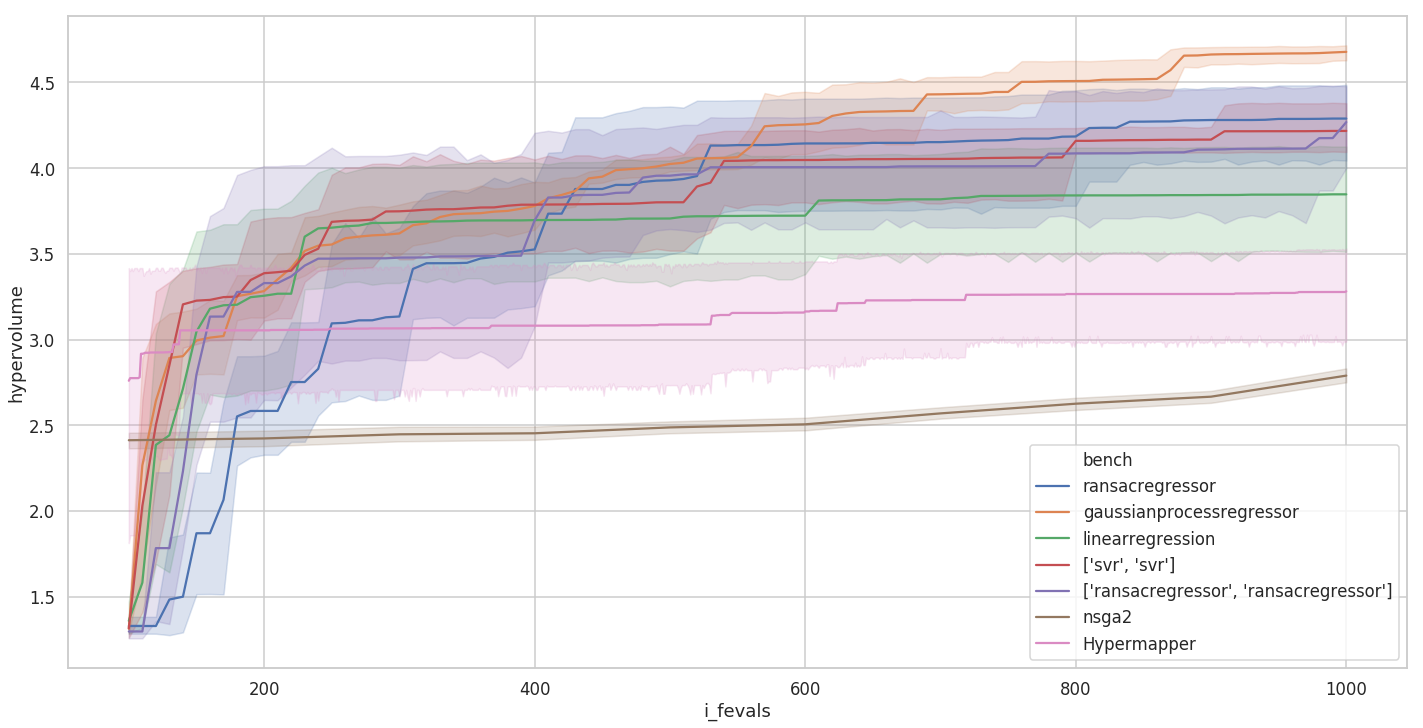

In [101]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(24, 12))

temp_fig = sns.lineplot(x="i_fevals", y="hypervolume", hue="bench", markers=True,
             palette="deep",
             data=pd.concat([fix_model, nsga2_df, mapper_df]))
temp_fig

___
## Portfolio with single and compositional models
 \+ NSGA2 and Hypermapper 2.0

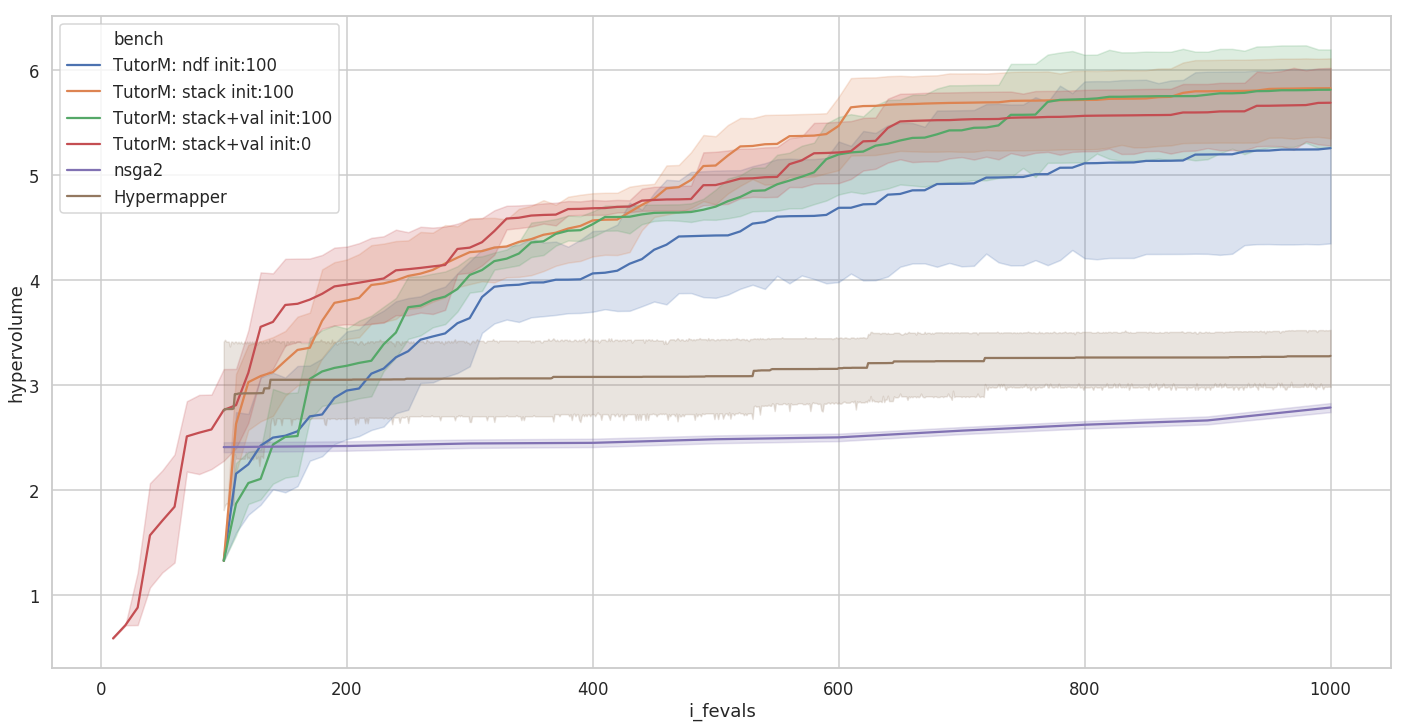

In [97]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(24, 12))

temp = sns.lineplot(x="i_fevals", y="hypervolume", hue="bench", markers=True,
             palette="deep",
             data=pd.concat([b1_df, b2_df, b3_df, b4_df, nsga2_df, mapper_df]))
temp

___
## Overall compariso: Portfolio(TutorM) vs Static surrogate

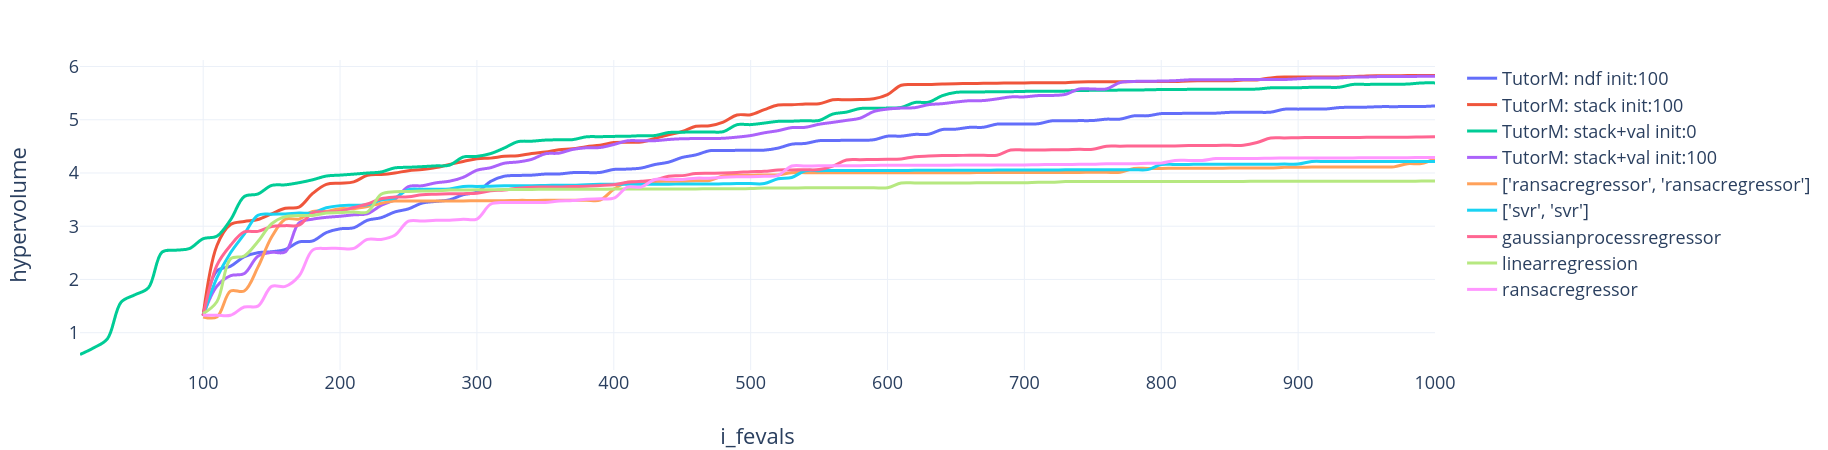

In [93]:
start_plot = px.line(pd.concat([b1_df, b2_df, b3_df, b4_df, fix_model]).groupby(['bench', 'i_fevals']).mean().reset_index(),  
            x="i_fevals", 
            y="hypervolume",
                     color='bench',
            hover_name="i_time", 
#             color_discrete_sequence=['rgb(150,0,90)', 'rgb(0,0,200)',  'rgb(151,255,0)', 'rgb(255,234,0)', 'rgb(255,111,0)', '#fe88ec'],
            template="presentation+plotly_white",
            line_shape="spline", 
            render_mode="svg")
start_plot

In [10]:
start_plot.write_image("./presentation/paper_tutorm.svg", width=1200, height=600)

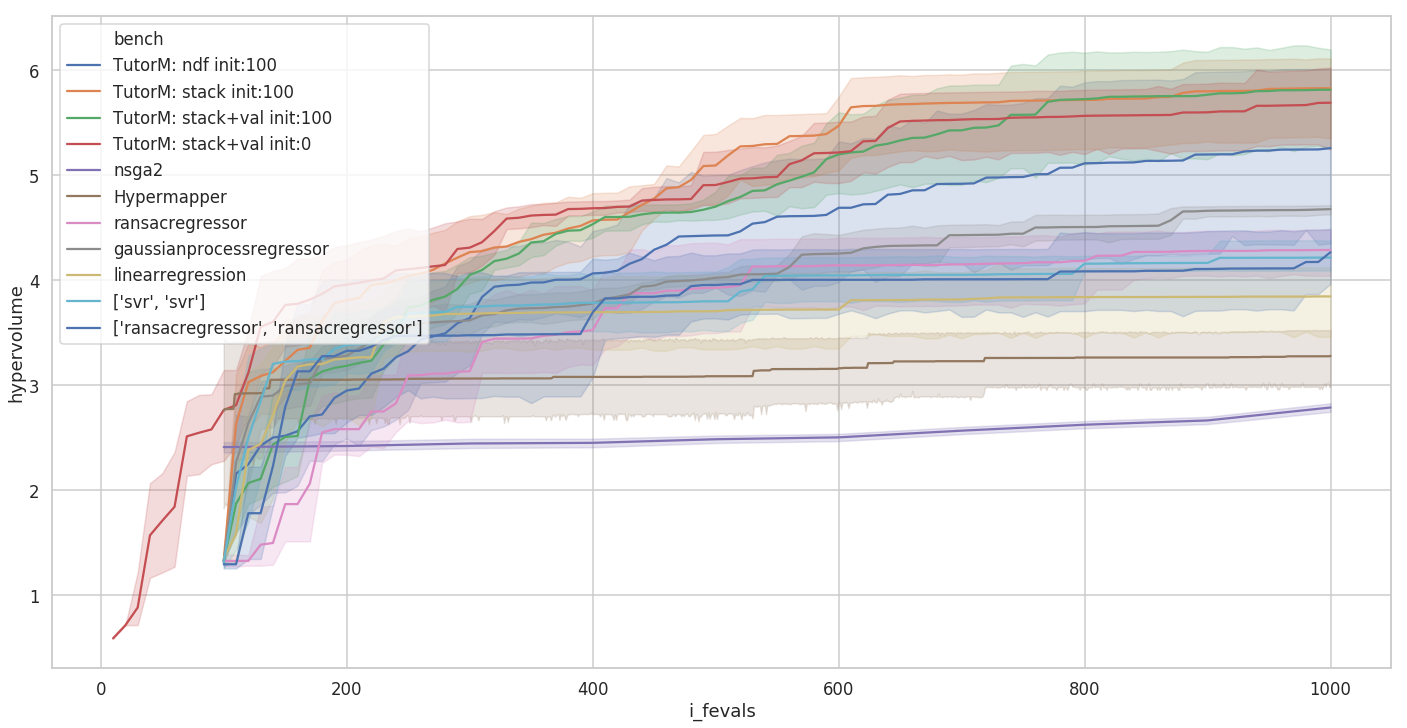

In [95]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(24, 12))

temp = sns.lineplot(x="i_fevals", y="hypervolume", hue="bench", markers=True,
             palette="deep",
             data=pd.concat([b1_df, b2_df, b3_df, b4_df, nsga2_df, mapper_df, fix_model]))
temp